In [1]:
from datetime import datetime, timedelta
import pytz
import yfinance as yf

def edt_to_utc(date, mask='%m/%d/%Y %I:%M%p'):
    """
    Convert EDT (Eastern Daylight Time) to UTC

    :param date: EDT date string e.g. '5/26/2014 4:00pm'
    :param mask: format of input date e.g '%m/%d/%Y %I:%M%'
    :return: UTC date string e.g '2014-03-05 12:23:00 UTC+0000'
    """
    utc = pytz.utc
    eastern = pytz.timezone('US/Eastern')
    date_ = datetime.strptime(date.replace(" 0:", " 12:"), mask)
    date_eastern = eastern.localize(date_, is_dst=None)
    date_utc = date_eastern.astimezone(utc)
    return date_utc.strftime('%Y-%m-%d %H:%M:%S %Z%z')

class Base(object):

    def __init__(self, symbol):
        self.symbol = symbol
        self._table = ''
        self._key = ''

    def _prepare_query(self, table='quotes', key='symbol', **kwargs):
        query = 'select * from yahoo.finance.{table} where {key} = "{symbol}"'.format(
            symbol=self.symbol, table=table, key=key)
        if kwargs:
            query += ''.join(f' and {k}="{v}"' for k, v in kwargs.items())
        return query

    def _request(self, query):
        response = yf.Ticker(self.symbol).history(period='1d')
        try:
            results = response.to_dict(orient='records')[0]
        except IndexError:
            raise YQLQueryError('No data available for the specified symbol.')
        else:
            self._change_incorrect_none(results)
            return results

    def _change_incorrect_none(self, results):
        for k, v in results.items():
            if v and 'N/A' in v:
                results[k] = None

    def _fetch(self):
        query = self._prepare_query(table=self._table, key=self._key)
        data = self._request(query)
        return data

    def refresh(self):
        self.data_set = self._fetch()

class Currency(Base):

    def __init__(self, symbol):
        super(Currency, self).__init__(symbol)
        self._table = 'xchange'
        self._key = 'pair'
        self.refresh()

    def _fetch(self):
        data = super(Currency, self)._fetch()
        if data['Date'] and data['Time']:
            data[u'DateTimeUTC'] = edt_to_utc('{0} {1}'.format(data['Date'], data['Time']))
        return data

    # Additional methods can be added based on specific requirements

class Share(Base):

    def __init__(self, symbol):
        super(Share, self).__init__(symbol)
        self._table = 'quotes'
        self._key = 'symbol'
        self.refresh()

    def _fetch(self):
        data = super(Share, self)._fetch()
        if data['LastTradeDate'] and data['LastTradeTime']:
            data[u'LastTradeDateTimeUTC'] = edt_to_utc('{0} {1}'.format(data['LastTradeDate'], data['LastTradeTime']))
        return data

    # Additional methods can be added based on specific requirements

    def get_historical(self, start_date, end_date):
        hist = yf.Ticker(self.symbol).history(start=start_date, end=end_date).reset_index().to_dict(orient='records')
        return hist


In [2]:
import yfinance as yf

# Example: Fetch historical data for Apple Inc. (AAPL) from 2020-01-01 to 2022-01-01
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2022-01-01'

data = yf.download(symbol, start=start_date, end=end_date)
print(data.head())


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  73.059425  135480400
2020-01-03  74.287498  75.144997  74.125000  74.357498  72.349129  146322800
2020-01-06  73.447502  74.989998  73.187500  74.949997  72.925644  118387200
2020-01-07  74.959999  75.224998  74.370003  74.597504  72.582664  108872000
2020-01-08  74.290001  76.110001  74.290001  75.797501  73.750252  132079200


In [3]:
print(data.tail())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-12-27  177.089996  180.419998  177.070007  180.330002  178.065659   
2021-12-28  180.160004  181.330002  178.529999  179.289993  177.038712   
2021-12-29  179.330002  180.630005  178.139999  179.380005  177.127579   
2021-12-30  179.470001  180.570007  178.089996  178.199997  175.962387   
2021-12-31  178.089996  179.229996  177.259995  177.570007  175.340317   

              Volume  
Date                  
2021-12-27  74919600  
2021-12-28  79144300  
2021-12-29  62348900  
2021-12-30  59773000  
2021-12-31  64062300  


In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,505.000000,505.000000,505.000000,505.000000,505.000000,5.050000e+02
mean,118.019624,119.459560,116.648331,118.123030,116.015851,1.241110e+08
std,29.455228,29.586384,29.270541,29.439688,29.313434,6.315499e+07
min,57.020000,57.125000,53.152500,56.092499,54.707001,4.100000e+07
25%,91.279999,92.970001,90.910004,91.632500,89.611061,8.086110e+07
50%,123.750000,125.180000,122.209999,123.750000,121.628738,1.088292e+08
75%,140.070007,142.210007,138.369995,141.110001,139.135086,1.477512e+08
max,181.119995,182.130005,178.529999,180.330002,178.065659,4.265100e+08


In [5]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
import pandas as pd

def fetch_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

def preprocess_data(stock_data):
    # Drop rows with missing values
    stock_data = stock_data.dropna()

    # Convert the index to a datetime object
    stock_data.index = pd.to_datetime(stock_data.index)

    return stock_data

def format_data(preprocessed_data):
    # Rename columns for better clarity
    preprocessed_data = preprocessed_data.rename(columns={
        'Open': 'Opening Price',
        'High': 'Highest Price',
        'Low': 'Lowest Price',
        'Close': 'Closing Price',
        'Adj Close': 'Adjusted Closing Price',
        'Volume': 'Trading Volume'
    })

    # Reset the index (optional)
    preprocessed_data = preprocessed_data.reset_index()

    # Convert data types if needed
    preprocessed_data['Trading Volume'] = preprocessed_data['Trading Volume'].astype(int)

    return preprocessed_data

# Example usage:
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2022-01-01'

# Fetch historical stock data
stock_data = fetch_stock_data(symbol, start_date, end_date)

# Preprocess the data
preprocessed_data = preprocess_data(stock_data)

# Format the data
formatted_data = format_data(preprocessed_data)

# Display the formatted data
print(formatted_data.head())



[*********************100%%**********************]  1 of 1 completed

        Date  Opening Price  Highest Price  Lowest Price  Closing Price  \
0 2020-01-02      74.059998      75.150002     73.797501      75.087502   
1 2020-01-03      74.287498      75.144997     74.125000      74.357498   
2 2020-01-06      73.447502      74.989998     73.187500      74.949997   
3 2020-01-07      74.959999      75.224998     74.370003      74.597504   
4 2020-01-08      74.290001      76.110001     74.290001      75.797501   

   Adjusted Closing Price  Trading Volume  
0               73.059425       135480400  
1               72.349129       146322800  
2               72.925644       118387200  
3               72.582664       108872000  
4               73.750252       132079200  


C:\Users\JAYANTH\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[*********************100%%**********************]  1 of 1 completed


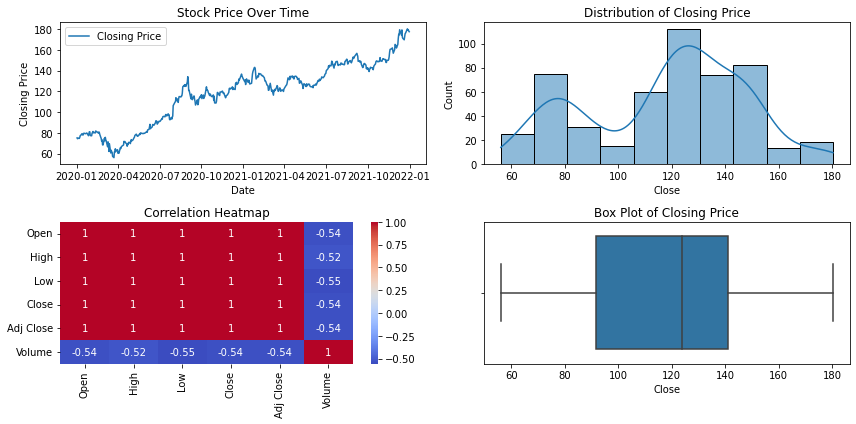

The mean closing price is 118.12, and the standard deviation is 29.44.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch historical stock data
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2022-01-01'
stock_data = yf.download(symbol, start=start_date, end=end_date)

# Preprocess the data
stock_data = stock_data.dropna()
stock_data['Date'] = pd.to_datetime(stock_data.index)

# Inferential Statistics
mean_price = stock_data['Close'].mean()
std_price = stock_data['Close'].std()

# Visualization of Stats
plt.figure(figsize=(12, 6))

# Time Series Plot
plt.subplot(2, 2, 1)
plt.plot(stock_data['Date'], stock_data['Close'], label='Closing Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()

# Distribution Plot
plt.subplot(2, 2, 2)
sns.histplot(stock_data['Close'], kde=True)
plt.title('Distribution of Closing Price')

# Correlation Heatmap
plt.subplot(2, 2, 3)
correlation_matrix = stock_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

# Box Plot
plt.subplot(2, 2, 4)
sns.boxplot(x=stock_data['Close'])
plt.title('Box Plot of Closing Price')

plt.tight_layout()
plt.show()

# Storytelling
print(f"The mean closing price is {mean_price:.2f}, and the standard deviation is {std_price:.2f}.")

# Dashboarding Stats (Narrative not included due to code complexity)
# You can use a tool like Power BI, Tableau, or Excel to create an interactive dashboard.
